<a href="https://colab.research.google.com/github/MarianoChic09/MSc-AI-taller-de-deep-learning/blob/main/NLP_Transformers_Letra_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer

En este laboratorio vamos a implementar una arquitectura de transformer desde cero. Recuerden usar la GPU de colab para acelerar el entrenamiento.

In [1]:
# !pip install spacy
# !pip install typing_extensions==4.7.1
!pip install torch==1.11.0 torchtext==0.6.0 #-f https://download.pytorch.org/whl/torch_stable.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.11.0 which is incompatible.
torchvision 0.16.0+cu118 requires torch==2.1.0, but you have torch 1

In [2]:
import copy
import math
import random
import time

import pandas as pd
import spacy
import torch
import torch.nn as nn
import torchtext
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
# from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torchtext.data import Field, BucketIterator, TabularDataset


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Download English and French data from Spacy
spacy.cli.download("en")
spacy.cli.download("fr")

Using device: cuda:0
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ As of spaCy v3.0, shortcuts like 'fr' are deprecated. Please use the
full pipeline package name 'fr_core_news_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


# Datos

Vamos a seguir trabajando con los datos de parejas de oraciones en Frances-w Inglés.

    I am cold.    J'ai froid.


In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2023-11-14 23:56:24--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.126, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.09s   

2023-11-14 23:56:24 (32.2 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/I

In [4]:
# Take a peek at the dataset
dataset = pd.read_csv("data/eng-fra.txt", sep="\t", header=None)
dataset.columns = ["English", "French"]
dataset

,English,French
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !
...,...,...
135837,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
135838,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
135839,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...
135840,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...


In [5]:
# dataset = dataset.sample(int(len(dataset)*0.4))

In [6]:
# Remove very long sentences

MAX_SEQ_LEN = 50

dataset['en_len'] = dataset['English'].str.count(' ')
dataset['fr_len'] = dataset['French'].str.count(' ')
dataset = dataset[
    (dataset['fr_len'] < MAX_SEQ_LEN) &
    (dataset['en_len'] < MAX_SEQ_LEN)
][['English', 'French']]

In [7]:
# Split dataset into train, val and test
train, val_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
val, test = train_test_split(val_test, test_size=0.5)

# Save splits to CSV files
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

In [8]:
# Load English and French models
en = spacy.load('en_core_web_sm')
fr = spacy.load('fr_core_news_sm')

def tokenize_en(sentence):
    return [tok.text for tok in en.tokenizer(sentence)]

def tokenize_fr(sentence):
    return [tok.text for tok in fr.tokenizer(sentence)]

EN_TEXT = Field(tokenize=tokenize_en, fix_length=MAX_SEQ_LEN)
FR_TEXT = Field(tokenize=tokenize_fr, init_token = "<sos>", eos_token = "<eos>", fix_length=MAX_SEQ_LEN)

In [9]:
# Associate the text in the 'English' column with the EN_TEXT field,
# and 'French' with FR_TEXT
data_fields = [('English', EN_TEXT), ('French', FR_TEXT)]

train, val = TabularDataset.splits(
    path='./',
    train='train.csv',
    validation='val.csv',
    format='csv',
    fields=data_fields
)

In [43]:
# Build vocabularies
FR_TEXT.build_vocab(train, val)
EN_TEXT.build_vocab(train, val)

# Construct a train iterator
train_iter = BucketIterator(
    train,
    batch_size=128,
    sort_key=lambda x: len(x.French),
    shuffle=True
)

# Armando el transformer paso a paso

![Transformer architecture](https://miro.medium.com/max/1140/1*2vyKzFlzIHfSmOU_lnQE4A.png)

El diagrama ilustra el modelo que vamos a implementar. Los inputs al encoder son las oraciones en Frances, y los "Outputs" que entran al decoder son las sentencias en Inglés.

Necesitamos entender 5 procesos para implementar el modelo:
- Embedding de los inputs
- Encoding Posicional
- Creación de máscaras
- La capa de Multi-Head Attention
- La capa Feed-Forward

## Encoding Posicional
----
El embedding de cada palabra aprende su significado, ahora necesitamos una manera de que la red aprenda sobre la posicion de cada palabra en la sentencia.

[Vaswani *et al.*](https://arxiv.org/abs/1706.03762) respondió esta pregunta usando las siguientes funciones para crear valores constantes relacionados a cada posición:

$$ PE_{(pos, 2i)} = sin\left(\frac{pos}{10000^{2i/d_{model}}}\right) $$
$$ PE_{(pos, 2i+1)} = cos\left(\frac{pos}{10000^{2i/d_{model}}}\right) $$

Esta constante es una matriz en 2D con una de las dimensiones de igual tamaño que los embeddings y la otra igual a la cantidad de palabras en la sentencia.

![Positional encoding matrix](https://miro.medium.com/max/1359/1*B-VR6R5vJl3Y7jbMNf5Fpw.png)

![Positional encoding example](http://jalammar.github.io/images/t/transformer_positional_encoding_example.png)

POsitional encoding le da al modelo una sensacion de temporalidad (por eso introduce seno y coseno) [Parecido a electronica]

In [71]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len=MAX_SEQ_LEN, dropout=0.1):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        # Create constant 'pe' matrix with values dependant on pos and i
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = 1.0 / torch.pow(10000, torch.arange(0, d_model, 2).float() / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # We register them as a buffer so the optimzer doesn't see this as parameters of the model to optimize!
        self.register_buffer('pe', pe)


    def forward(self, x):
        # Make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        # Add constant to embedding
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [72]:
MAX_SEQ_LEN = 100
d_model = 4
pos_enc = PositionalEncoder(d_model, MAX_SEQ_LEN , 0) # d_model es el largo de embeddings, max_seq_len largo maximo de la secuencia
example = torch.zeros(1,MAX_SEQ_LEN,d_model)

In [73]:
pos_enc(example)

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.9093, -0.4161,  0.0200,  0.9998],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [-0.7568, -0.6536,  0.0400,  0.9992],
         [-0.9589,  0.2837,  0.0500,  0.9988],
         [-0.2794,  0.9602,  0.0600,  0.9982],
         [ 0.6570,  0.7539,  0.0699,  0.9976],
         [ 0.9894, -0.1455,  0.0799,  0.9968],
         [ 0.4121, -0.9111,  0.0899,  0.9960],
         [-0.5440, -0.8391,  0.0998,  0.9950],
         [-1.0000,  0.0044,  0.1098,  0.9940],
         [-0.5366,  0.8439,  0.1197,  0.9928],
         [ 0.4202,  0.9074,  0.1296,  0.9916],
         [ 0.9906,  0.1367,  0.1395,  0.9902],
         [ 0.6503, -0.7597,  0.1494,  0.9888],
         [-0.2879, -0.9577,  0.1593,  0.9872],
         [-0.9614, -0.2752,  0.1692,  0.9856],
         [-0.7510,  0.6603,  0.1790,  0.9838],
         [ 0.1499,  0.9887,  0.1889,  0.9820],
         [ 0.9129,  0.4081,  0.1987,  0.9801],
         [ 0.

## Máscaras para los inputs
----
Las máscaras de ceros cumplen dos propósitos:

- En **ambos** encoder y decoder: Para obtener 0s en la atención sobre el padding.
- En el **decoder**: Prevenir que el decoder "espíe" a los siguientes inputs de la secuencia traducida, el futuro que no debería conocer para predecir la siguiente palabra. Evita que el decoder "vea" lo que tiene que predecir antes de predecirlo.

In [74]:
def build_attn_pad_mask(seq, pad_index):
    # Creates mask with 0s wherever there is padding in the input
    return (seq != pad_index).unsqueeze(1).type(torch.uint8)


def build_nopeak_mask(size):
    # Creates mask with 1s up until the the index of the word being predicted
    nopeak_mask = torch.triu(torch.ones(size, size)).transpose(0, 1)
    return nopeak_mask.unsqueeze(0).type(torch.uint8)

def create_masks(src, src_pad, trg=None, trg_pad=None):
    src_mask = build_attn_pad_mask(src, src_pad)

    if trg is not None:
        trg_mask = build_attn_pad_mask(trg, trg_pad)
        size = trg.size(1) # get seq_len for matrix
        np_mask = build_nopeak_mask(size)
        trg_mask = trg_mask & np_mask
    else:
        trg_mask = None

    return src_mask, trg_mask

In [75]:
example_tensor = torch.tensor([[4,5,3,666,666,666,666]])
build_attn_pad_mask(example_tensor,666)

tensor([[[1, 1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

In [76]:
build_nopeak_mask(len(example_tensor[0]))

tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)

In [77]:
example_target_tensor = torch.tensor([[1,2,3,28,28,28,28]])

In [78]:
masks = create_masks(example_tensor, 666,example_target_tensor,28)

In [79]:
example_target_tensor * masks[1] # esto es lo que hace el transformer, tiene todo de una para poder procesarlo

tensor([[[1, 0, 0, 0, 0, 0, 0],
         [1, 2, 0, 0, 0, 0, 0],
         [1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 0, 0, 0, 0],
         [1, 2, 3, 0, 0, 0, 0]]])

## Multi-Head Attention
----

![Multihead attention schema](https://miro.medium.com/max/1254/1*1tsRtfaY9z6HxmERYhw8XQ.png)

$V$, $K$ y $Q$ reprensentan ‘key’, ‘value’ and ‘query’. En el caso del Encoder, $V$, $K$ and $Q$ serán simplemente copias idénticas del vector de embedding (junto con el encoding posicional). Tendrán las siguientes dimensiones $\text{batch_size} \times \text{seq_len} \times d_\text{model}$.

En multi-head attention repartimos el vector de embedding en $N$ cabezas, por lo que tendrán las dimensiones: $\text{batch_size} \times N \times \text{seq_len} \times (d_{\text{model}} / N)$.

La dimensión final: ($d_{\text{model}} / N$) es a lo que llamaremos $d_k$.

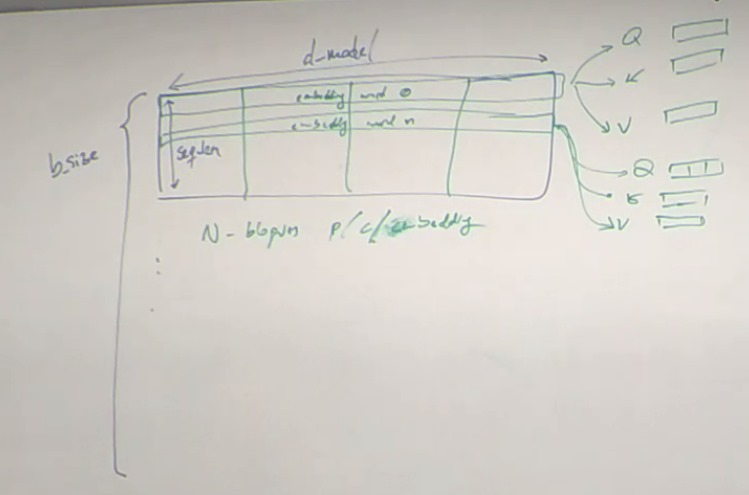

In [80]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, attn_pdrop = 0.1, resid_pdrop = 0.1):
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        # Q, K, V
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        # Regularization
        self.attn_dropout  = nn.Dropout(attn_pdrop)
        self.residual_dropout = nn.Dropout(resid_pdrop)

        # Output projection
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # Get batch size
        bs = q.size(0)

        # Perform linear operation and split into h heads
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        # Transpose to get dimensions bs * h * sl * d_k
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        # Calculate attention scores using function we will define next

        scores = attention(q,k,v,self.d_k,mask, self.attn_dropout)

        # Re-assemble all head outputs side by side
        # Need to use contigous here to get correspondence
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)

        # Output projection

        output = self.residual_dropout(self.out(concat))

        return output

### Mecanismo de Atención
----

![Attention diagram](https://miro.medium.com/max/336/1*15E9qKg9bKnWdSRWCyY2iA.png)
![Attention equation](https://miro.medium.com/max/1068/1*evdACdTOBT5j1g1nXialBg.png)

Inicialmente, multiplicamos $Q$ por la transpuesta de $K$. Esto es luego dividipo por $\sqrt{d_k}$ (normalización).

Algo que aún no vimos es qué hacer con atención y las máscaras. Antes de hacer el Softmax, aplicamos nuestra máscara de ceros para reducir los valores donde el input es padding (o futuro).

Finalmente, el último paso es hacer el producto (dot product) entre el resultado hasta ahora y $V$.

In [81]:
q = torch.rand(5,4,3,2)
k = torch.rand(5,4,3,2)
v = torch.ones(5,4,3,2)
example_tensor = torch.tensor([[4,5,666]])
example_batch = example_tensor * torch.ones(5,8,3)



example_target_tensor = torch.tensor([[1,2,3,28,28,28,28]])
mask = build_attn_pad_mask(example_batch,666).transpose(1,2)
example_mask = mask.reshape(5,4,3,2)

In [82]:
# attention(q,k,v,2, example_mask)

dimensiones: (batch_size, head, s_l, d_k)
s_l => sequence length
d_k => embedding sizes.

No transpone todo solo las ultimas dos dimensiones:
=> Q*Kt =>
Q =  (batch_size, head, s_l, d_k) ej. (32,5,5,2)
Kt =  (batch_size, head, d_k, s_l) ej. (32,5,2,5)

QKt = (batch_size, head, s_l, s_l) ej. (32,5,5,5)

V = (batch_size, head, s_l, d_k) ej. (32,5,5,2)
MATHMUL SI TENES MAS DE DOS DIMENSIONES OPERA SOBRE LAS ULTIMAS DOS.

In [83]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
        scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

## Capa Feed-Forward
----
Esta capa solo consiste en dos opeaciones lineales (nn.Linear) con ReLU y dropout entre ellas.

In [84]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff = 2048, dropout = 0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
    def forward(self,x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

# Combinando todo

Vamos a crear una capa EncoderLayer y DecoderLayer que agrupan los componentes necesarios para crear un solo encoder (o decoder).

Luego, creamos el Encoder de nuestra arquitectura, conteniendo N de estos bloques anteriores. Repetimos para el decoder.

![Transformer architecture](https://miro.medium.com/max/1140/1*2vyKzFlzIHfSmOU_lnQE4A.png)


In [85]:
# Build an encoder layer with one multi-head attention layer and one
# feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(heads, d_model, dropout, dropout)
        self.ff = FeedForward(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        x = x + self.dropout(self.attn(x,x,x,mask))
        x = x + self.dropout(self.ff(x))
        return x

# Build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        x = x + self.dropout(self.attn_1(x,x,x,trg_mask))
        x = x + self.dropout(self.attn_2(x,e_outputs,e_outputs,src_mask))
        x = x + self.dropout(self.ff(x))
        return x

# Convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [86]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)

    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)

    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x,e_outputs,src_mask, trg_mask)
        return x

Finalmente usando los dos bloques anteriores y una capa linear creamos el transformer con $N$ encoders/decoders!

In [87]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)

    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Entrenando

In [88]:
d_model = 512
heads = 4
N = 3
src_vocab = len(EN_TEXT.vocab) # No es trivial como inicializo los parametros.
trg_vocab = len(FR_TEXT.vocab)

model = Transformer(src_vocab, trg_vocab, d_model, N, heads).to(DEVICE)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# This code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation:
# https://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

In [89]:
def train_model(epochs, print_every=100):
    model.train()

    start = time.time()
    temp = start
    total_loss = 0

    src_pad = EN_TEXT.vocab.stoi['<pad>']
    trg_pad = FR_TEXT.vocab.stoi['<pad>']

    for epoch in range(epochs):
        total_loss = 0
        for i, batch in enumerate(train_iter):
            src = batch.English.transpose(0, 1)
            trg = batch.French.transpose(0, 1)
            # the French sentence we input has all words except
            # the last, as it is using each word to predict the next
            trg_input = trg[:, :-1]

            # the words we are trying to predict
            targets = trg[:, 1:].contiguous().view(-1)

            # create function to make masks using mask code above
            src_mask, trg_mask = create_masks(src, src_pad, trg_input, trg_pad)

            preds = model(src.to(DEVICE), trg_input.to(DEVICE), src_mask.to(DEVICE), trg_mask.to(DEVICE))

            optim.zero_grad()

            loss = F.cross_entropy(
                preds.view(-1, preds.size(-1)),
                targets.to(DEVICE),
                ignore_index=trg_pad
            )

            loss.backward()
            optim.step()
            total_loss += loss.item()
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f, %ds per %d iters" % (
                    (time.time() - start) // 60, epoch + 1, i + 1, loss_avg, time.time() - temp, print_every)
                )
                total_loss = 0
                temp = time.time()

In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.0002)

train_model(1) # Train for 10 epochs (~60min)

time = 0m, epoch 1, iter = 100, loss = 8.705, 41s per 100 iters


In [ ]:
def translate(model, src, max_len=80):
  model.eval()

  input_pad = EN_TEXT.vocab.stoi['<pad>']

  src = tokenize_en(src)
  src = (torch.LongTensor([[EN_TEXT.vocab.stoi[tok] for tok in src]])).cuda()

  src_mask = (src != input_pad).unsqueeze(-2).cuda()
  e_outputs = model.encoder(src, src_mask)

  outputs = torch.zeros(max_len).type_as(src.data)
  outputs[0] = torch.LongTensor([FR_TEXT.vocab.stoi['<sos>']])

  for i in range(1, max_len):
    trg_mask = torch.triu(torch.ones((1, i, i))).type(torch.uint8)
    trg_mask = ((trg_mask) == 0).cuda()

    out = model.out(model.decoder(outputs[:i].unsqueeze(0), e_outputs, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)
    val, ix = out[:, -1].data.topk(1)

    outputs[i] = ix[0][0]

    if ix[0][0] == FR_TEXT.vocab.stoi['<eos>']:
        break

  return ' '.join([FR_TEXT.vocab.itos[ix] for ix in outputs[:i]])

In [ ]:
translate(model, "How are you ?")